In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)

# Hide the code completely

# from IPython.display import HTML
# tag = HTML('''<style>
# div.input {
#     display:none;
# }
# </style>''')
# display(tag)

In [2]:
%matplotlib notebook
import scipy.signal as signal
import matplotlib.pyplot as plt
from ipywidgets import widgets
from ipywidgets import interact
import numpy as np
import sympy as sym

## PID regulator - vremenski odziv

Proporcionalno-integracijsko-derivacijski (PID) algoritam upravljanja daleko je najpoznatiji i najčešće korišteni algoritam automatskog upravljanja. Njegova prijenosna funkcija je

\begin{equation}
    P(s)=K_p \cdot \left( 1 + \frac{1}{T_i s} + T_d s \right).
\end{equation}

Funkcija predstavlja zbroj proporcionalnog, integracijskog i derivacijskog kanala. Ne moraju svi nužno biti prisutni, pa se koriste i algoritmi upravljanja PI ili PD. U ovom primjeru prikazuje se vremenski odziv P, PI, PD ili PID regulatora za ulazne signale iz skupa: step-funkcija, impuls, rampa i sinus.

---

### Kako koristiti ovaj interaktivni primjer?
1. Izaberite između *jedinična step funkcija*, *jedinična impulsna funkcija*, *rampa funkcija* i *funkcija sinus* za odabir ulaznog signala.
2. Kliknite na gumb *P*, *PI*, *PD* ili *PID* za odabir između proporcionalnog, proporcionalno-integracijskog, proporcionalno-derivacijskog ili proporcionalno-integracijsko-derivacijskog tipa algoritma upravljanja.
3. Pomičite klizače da biste promijenili vrijednosti proporcionalnog ($K_p$), integracijskog ($T_i$) i derivacijskog ($T_d$) koeficijenta PID regulacije.
4. Pomičite klizač $t_{max}$ za promjenu maksimalne vrijednosti vremena na osi x.

<IPython.core.display.Javascript object>


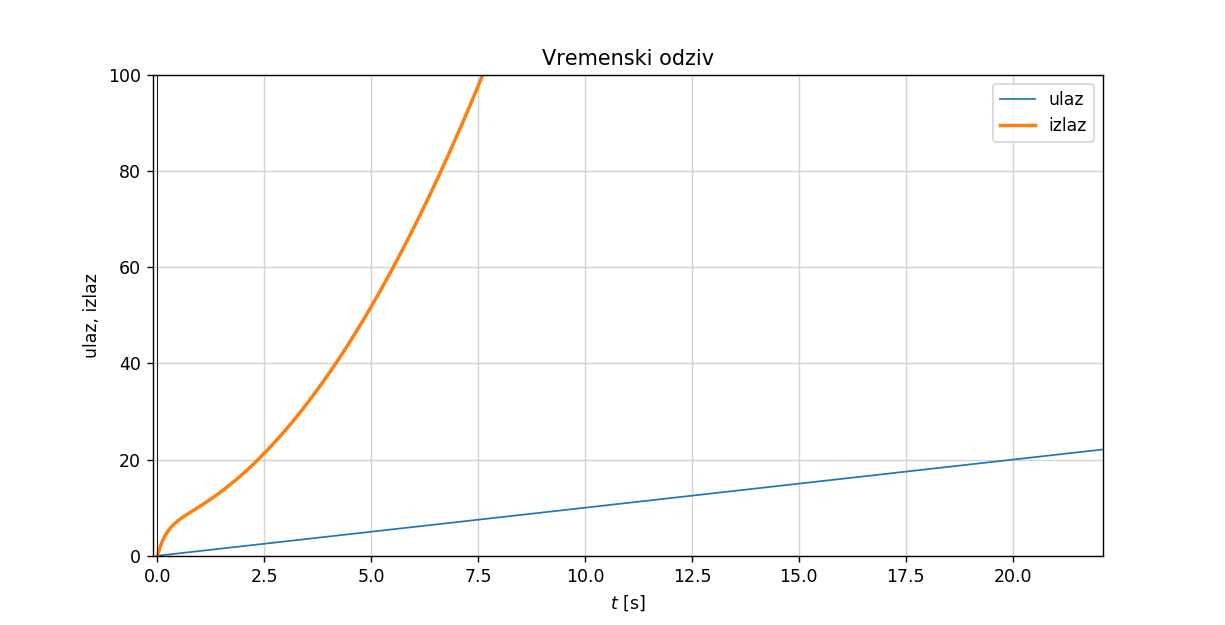

ToggleButtons(description='Odaberite ulazni signal:', options=('jedinična step funkcija', 'jedinična impulsna …

ToggleButtons(description='Odaberite tip algoritma upravljanja:', options=('P', 'PI', 'PD', 'PID'), style=Togg…

interactive(children=(IntSlider(value=20, description='\\(K_p \\)', min=1, readout_format='.1d'), FloatSlider(…

In [3]:
a = 0.1

# make figure
fig = plt.figure(figsize=(9.8, 5),num='PID regulator')
# add axes
ax = fig.add_subplot(111)
ax.grid(which='both', axis='both', color='lightgray')
ax.set_title('Vremenski odziv')
# plot step function and responses (initalisation)
input_plot, = ax.plot([],[],'C0', linewidth=1,label='ulaz')
response_plot, = ax.plot([],[], 'C1', linewidth=2,label='izlaz')
ax.axhline(linewidth=.5, color='k')
ax.axvline(linewidth=.5, color='k')
ax.legend()

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('ulaz, izlaz')
plt.show()

P, I, D, s = sym.symbols('P, I, D, s')

input_type = 'jedinična step funkcija' #input function
Time_span = 10 # max time on x-axis plot

#initialize global variables
KP = 1.
TI = 1.
TD = 1.
num = []
den = []

def update_plot():
    global num, den, input_type, Time_span
    num_temp = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in num]
    den_temp = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in den]
    
    system = signal.TransferFunction(num_temp, den_temp)
    
    #time, response = signal.step(system) #only for setting time borders (for nicer plot. could also calculate dominant frequency)
    #time = np.linspace(0,time[-1],1000)
    time = np.linspace(0, Time_span, 600)
    
    if input_type == 'jedinična step funkcija':
        u = np.ones_like(time)
        u = np.concatenate((np.array([0]),u))
        time, response = signal.step(system, T=time)
        time = np.concatenate((np.array([0]), time))
        response = np.concatenate((np.array([0]), response))
    elif input_type == 'jedinična impulsna funkcija':
        u = np.zeros_like(time)
        u = np.concatenate((np.array([10]), u))
        time, response = signal.impulse(system, T=time)
        time = np.concatenate((np.array([0]), time))
        response = np.concatenate((np.array([0]), response))
    elif input_type == 'funkcija sinus':
        u = np.sin(time*2*np.pi)
        time, response, _ = signal.lsim(system, U=u, T=time)
    elif input_type == 'rampa funkcija':
        u = time
        time, response, _ = signal.lsim(system, U=u, T=time)
    else:
        raise Exception("Greška u programu. Ponovno pokrenite simulaciju.")
    
    response_plot.set_data(time, response)
    input_plot.set_data(time, u)
    ax.set_ylim([min([np.min(u), min(response),-.1]),min(100,max([max(response)*1.05, 1, 1.05*np.max(u[1:])]))])
    ax.set_xlim([-0.1,max(time)])
    plt.show()
    

def transfer_func(controller_type):
    global num, den
    proportional = P
    integral = P/(I*s)
    differential = P*D*s/(a*D*s+1)
    if controller_type =='P':
        controller_func = proportional
        Kp_widget.disabled=False
        Ti_widget.disabled=True
        Td_widget.disabled=True
    elif controller_type =='PI':
        controller_func = proportional+integral
        Kp_widget.disabled=False
        Ti_widget.disabled=False
        Td_widget.disabled=True
    elif controller_type == 'PD':
        controller_func = proportional+differential
        Kp_widget.disabled=False
        Ti_widget.disabled=True
        Td_widget.disabled=False
    else:
        controller_func = proportional+integral+differential
        Kp_widget.disabled=False
        Ti_widget.disabled=False
        Td_widget.disabled=False
    system_func = controller_func
    
    num = [sym.fraction(system_func.factor())[0].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func.factor())[0], gen=s)))]
    den = [sym.fraction(system_func.factor())[1].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func.factor())[1], gen=s)))]
    update_plot()
    
def func(Kp, Ti, Td, time_span):
    global KP, TI, TD, Time_span
    KP = Kp
    TI = Ti
    TD = Td
    Time_span = time_span
    update_plot()
    
style = {'description_width': 'initial'}

def buttons_controller_clicked(event):
    controller = buttons_controller.options[buttons_controller.index]
    transfer_func(controller)
buttons_controller = widgets.ToggleButtons(
    options=['P', 'PI', 'PD', 'PID'],
    description='Odaberite tip algoritma upravljanja:',
    disabled=False,
    style=style)
buttons_controller.observe(buttons_controller_clicked)

def buttons_input_clicked(event):
    global input_type
    input_type = buttons_input.options[buttons_input.index]
    update_plot()
buttons_input = widgets.ToggleButtons(
    options=['jedinična step funkcija','jedinična impulsna funkcija', 'rampa funkcija', 'funkcija sinus'],
    description='Odaberite ulazni signal:',
    disabled=False,
    style=style)
buttons_input.observe(buttons_input_clicked)


Kp_widget = widgets.IntSlider(value=20,min=1,max=100,step=1,description=r'\(K_p \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.1d')
Ti_widget = widgets.FloatSlider(value=.1,min=0.001,max=3.,step=0.001,description=r'\(T_{i} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.3f')
Td_widget = widgets.FloatSlider(value=.1,min=0.001,max=3.,step=0.001,description=r'\(T_{d} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.3f')

time_span_widget = widgets.FloatSlider(value=10.,min=.5,max=50.,step=0.1,description=r'\(t_{max} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.1f')

transfer_func('P')

display(buttons_input)
display(buttons_controller)

interact(func, Kp=Kp_widget, Ti=Ti_widget, Td=Td_widget, time_span=time_span_widget);